# MPI validation
Comparison between MPI climate model and ORAS5

## Imports

In [1]:
import warnings
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import xarray as xr
from climpred import HindcastEnsemble
from dateutil.relativedelta import *
from matplotlib.ticker import AutoMinorLocator
import warnings
import tqdm
import pathlib
import cmocean
import pandas as pd

# Import custom modules
from src.XRO import XRO, xcorr
import src.utils

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

In [2]:
def get_ensemble_stats(ensemble, center_method="mean", bounds_method="std"):
    """compute ensemble 'center' and 'bounds' for plotting"""

    ## compute ensemble 'center'
    if center_method == "mean":
        center = ensemble.mean("member")
    else:
        print("Not implemented")

    ## compute bounds
    if bounds_method == "std":
        sigma = ensemble.std("member")
        upper_bound = center + sigma
        lower_bound = center - sigma
    else:
        print("Not implemented")

    ## concatenate into single array
    posn_dim = pd.Index(["center","upper","lower"], name="posn")
    stats = xr.concat([center, upper_bound, lower_bound], dim=posn_dim)

    return stats

    # return center, upper_bound, lower_bound

## Load data

In [3]:
## MPI data
mpi_load_fp = pathlib.Path("/Users/theo/research/enso2025_xro/data/mpi_Th/Th.nc")
Th_mpi = xr.open_dataset(mpi_load_fp)

## ORAS5 reanalysis (use as benchmark)
oras_load_fp = pathlib.Path("../data/XRO_indices_oras5.nc")
Th_oras = xr.open_dataset(oras_load_fp)

## rename variables for consistency and trim so time periods covered are the same
Th_mpi = Th_mpi.sel(time=slice("1979", "2024"))
Th_oras = Th_oras[["Nino34", "WWV"]].rename({"Nino34": "T_34", "WWV": "h"})

## Diagnostics

### Seasonal synchronization

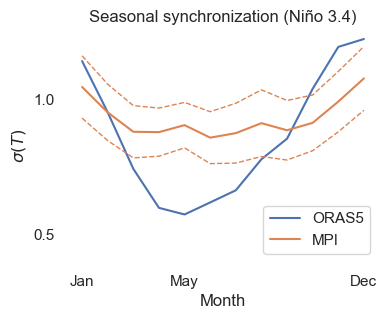

In [4]:
## func to compute std dev as a function of month
get_std = lambda x: x.groupby("time.month").std("time")

## compute std for each dataset
oras_std = get_std(Th_oras["T_34"])
mpi_std = get_std(Th_mpi["T_34"])
mpi_std_plot = get_ensemble_stats(mpi_std)

## months (x-coordinate for plotting
months = np.arange(1, 13)

### Set up plot
fig, ax = plt.subplots(figsize=(4, 3))

## plot for ORAS5
oras_plot = ax.plot(months, oras_std, label="ORAS5")

## plot MPI ensemble mean
mpi_plot = ax.plot(months, mpi_std_plot.sel(posn="center"), label="MPI")

## plot MPI bounds
kwargs = dict(c=mpi_plot[0].get_color(), ls="--", lw=1)
for bound in ["upper", "lower"]:
    ax.plot(months, mpi_std_plot.sel(posn=bound), **kwargs)

## adjust limits and label
ax.set_ylim([0.4, None])
ax.set_yticks([0.5, 1])
ax.set_xticks([1, 5, 12], labels=["Jan", "May", "Dec"])
ax.set_xlabel("Month")
ax.set_ylabel(f"$\\sigma(T)$")
ax.set_title("Seasonal synchronization (Niño 3.4)")
ax.legend()
plt.show()

### $T,h$ cross-correlation

Compute stats

In [5]:
## compute cross-correlation
xcorr_oras = xcorr(Th_oras, Th_oras["T_34"], maxlags=18)
xcorr_mpi = xcorr(Th_mpi, Th_mpi["T_34"], maxlags=18)

## compute MPI stats
xcorr_mpi_stats = get_ensemble_stats(xcorr_mpi)

Plotting funcs

In [6]:
def format_axs(axs):
    ## add axis lines to plots
    axis_kwargs = dict(c="k", lw=0.5, alpha=0.5)
    for ax in axs.flatten():
        ax.axhline(0, **axis_kwargs)
        ax.axvline(0, **axis_kwargs)
        ax.set_ylim([-0.7, 1.1])

    #### label plots

    ## bottom row
    for ax in axs[1]:
        ax.set_xlabel("Lag (years)")
        ax.set_xticks([-12, 0, 12], labels=[-1, 0, 1])

    ## top row
    for ax in axs[0]:
        ax.set_xticks([])

    ## left col
    for ax in axs[:, 0]:
        ax.set_ylabel("Correlation")

    ## right col
    for ax in axs[:, 1]:
        ax.set_yticks([])

    return axs

def plot_oras(ax, data, color, label=None):
    """Plot curve for oras"""
    
    ax.plot(data.lag, data, c=color, label=label)
    
    return 

def plot_mpi(ax, data, color, label=None):
    """plot mean and bounds for MPI"""

    ## center
    ax.plot(
        data.lag,
        data.sel(posn="center"),
        c=color,
        ls="--",
        label=label,
    )

    ## bounds
    ax.fill_between(
        data.lag, 
        data.sel(posn="upper"), 
        data.sel(posn="lower"), 
        color=color, 
        alpha=0.2
    )
    
    return

Make plot

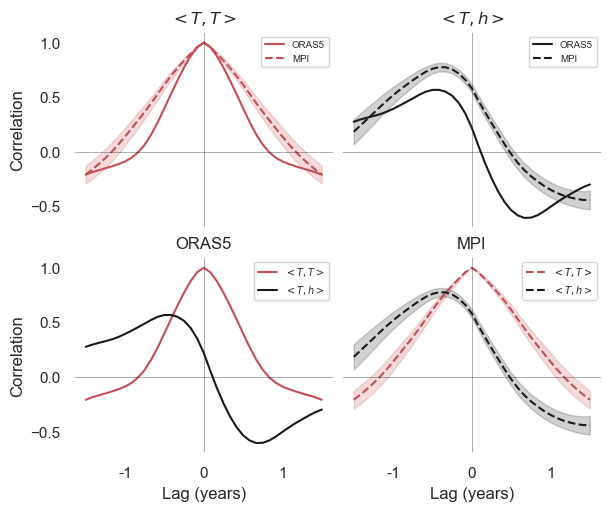

In [7]:
## specify plot properties for legend
legend_prop = dict(size=7)

fig, axs = plt.subplots(2, 2, figsize=(6, 5), layout="constrained")

## plot <T,T>
axs[0,0].set_title(r"$<T, T>$")
plot_oras(axs[0, 0], xcorr_oras["T_34"], color="r", label="ORAS5")
plot_mpi(axs[0, 0], xcorr_mpi_stats["T_34"], color="r", label="MPI")

## plot <T,h>
axs[0,1].set_title(r"$<T, h>$")
plot_oras(axs[0,1], xcorr_oras["h"], color="k", label="ORAS5")
plot_mpi(axs[0,1], xcorr_mpi_stats["h"], color="k", label="MPI")

## plot for ORAS5
axs[1,0].set_title("ORAS5")
plot_oras(axs[1,0], xcorr_oras["T_34"], color="r", label="$<T, T>$")
plot_oras(axs[1,0], xcorr_oras["h"], color="k", label="$<T, h>$")

## plot for MPI
axs[1,1].set_title("MPI")
plot_mpi(axs[1,1], xcorr_mpi_stats["T_34"], color="r", label="$<T, T>$")
plot_mpi(axs[1,1], xcorr_mpi_stats["h"], color="k", label="$<T, h>$")

## clean up axes
axs = format_axs(axs)

for ax in axs.flatten():
    ax.legend(prop=dict(size=7))

plt.show()

## Growth rate / periodicity

Functions to help growth rate computation

In [43]:
def get_timescales(model, fit):
    """Get annual cycle of growth rate and period estimate from RO parameters"""

    ## get parameters
    params = model.get_RO_parameters(fit)

    ## extract BJ index
    BJ_ac = params["BJ_ac"]

    ## extract period (based on annual avg.)
    L0 = fit["Lcomp"].isel(ac_rank=0, cycle=0)
    w, _ = np.linalg.eig(L0)
    T = 2*np.pi / w[0].imag

    return BJ_ac, T

def get_timescales_ensemble(model, fit_ensemble):
    """Get timescales for ensemble"""

    ## empty lists to hold results
    BJ_ac_ensemble = []
    T_ensemble = []

    ## loop through ensemble members
    for m in fit_ensemble.member:
        BJ_ac, T = get_timescales(model, fit_ensemble.sel(member=m))
        BJ_ac_ensemble.append(BJ_ac)
        T_ensemble.append(T)

    ## put in arrays
    BJ_ac_ensemble = xr.concat(BJ_ac_ensemble, dim=fit_ensemble.member)
    T_ensemble = np.array(T_ensemble)

    return BJ_ac_ensemble, T_ensemble

Do the computation

In [48]:
## initialize model
model = model = XRO(ncycle=12, ac_order=1, is_forward=True)

## get fit for reanalysis and model
fit_oras = model.fit_matrix(Th_oras[["T_34","h"]])
_, fit_mpi = src.utils.get_RO_ensemble(Th_mpi, T_var="T_34", h_var="h")

## compute timescales for each
bj_oras, period_oras = get_timescales(model, fit_oras)
bj_mpi, period_mpi = get_timescales_ensemble(model, fit_mpi)

/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)


Plot result

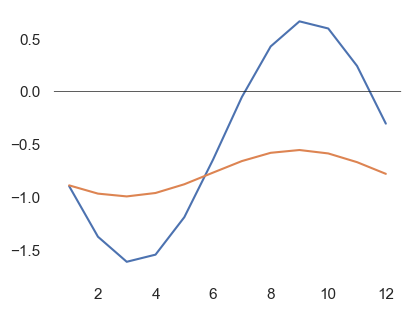

In [55]:
fig,ax = plt.subplots(figsize=(4,3), layout="constrained")

ax.plot(bj_oras.cycle, bj_oras, label=r"ORAS5")
ax.plot(bj_mpi.cycle, bj_mpi.mean("member"), label=r"ORAS5")

ax.axhline(0, c="k", ls="-", lw=0.5)